# Analysis

## Setup

In [147]:
############################################################################################################################ 
# Get the latest CREST files for each ID within the target folder (dirname)

from pathlib import Path
import json
from sqlite3 import connect as sqlite3_connect
from sqlite3 import DatabaseError
from igraph import Graph as ig_Graph
from igraph import plot as ig_plot
from scipy.spatial.distance import cdist
from random import choice as random_choice
from itertools import combinations
from numpy import array, unravel_index, argmin, mean
import random
import numpy as np
from copy import deepcopy
import itertools
from datetime import datetime
from time import time
import neuroglancer
from webbrowser import open as wb_open
from webbrowser import open_new as wb_open_new
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# from eCREST_cli_beta import ecrest, import_settings
from eCREST_cli import ecrest, import_settings

The 'ecrest' class has been imported from eCREST_cli.py

An instance of this object will be able to:
- open an neuroglancer viewer for proofrieading (see "Proofread using CREST")
    - add-remove segments (using graph feature for efficiency)
    - format itself and save itself as a CREST-style .json
- convert from neuroglancer json (see "Convert From Neuroglancer to eCREST")
    - format itself and save itself as a CREST-style .json
    


### Import settings

If you save a copy of settings_dict.json (found in the "under construction" directory of eCREST repo) locally somewhere outside the repo (like in your save_dir), then you can use the following code cell to import. This avoids needing to re-type the save_dir and db_path each time you "git pull" updates from the repo to this notebook.

In [148]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

In [149]:
dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

## Get all cells info

In [150]:
nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child

cell_type = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    cell_type[x] = cell.get_ctype('manual') 
    if (cell.get_ctype('manual') == []) | (cell.get_ctype('manual') == ''):
        print(f'cell {x} is not cell-typed in json')

In [17]:
# # # IF NEED TO CELL TYPE....


# json_path = Path(settings_dict['save_dir'])
# filename = 'cell_graph_644143297__2023-04-18 20.22.35.json'
# filepath = json_path / filename

# crest = ecrest(settings_dict,filepath= filepath)#, launch_viewer=False)


# # Assign the cell type and which method you are using (manual or auto)
# cell_type = 'mg1'
# method = 'manual'

# ## Do not edit
# crest.define_ctype(cell_type,method)

# crest.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); 

Saved cell 644143297 reconstruction locally at 2023-04-19 16.57.21


## Get all segments

In [151]:

# Create a base_segments dictionary of all reconstructed cells 
'''
when done, can this be saved as a json? maybe quicker to load than to re-go through all cells?
'''

base_segments = {}
for x in nodes:
    # if cell_type[x] in network_types: # if do this, you can't check if the post-syn segments exist as a reconstruction
    cell = ecrest(settings_dict,filepath = nodefiles[x])#,launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

## Build Graph

In [152]:
network_types = ['mg1','mg2','lg','lf']

In [153]:
ell = ig_Graph(directed = True) 
ell.add_vertices([n for n in nodes if cell_type[n] in network_types])

# assign cell types to each node
for x in ell.vs:
    x['cell_type'] = cell_type[x['name']]

In [ ]:
# use this code cell to delete some of the vertices (cells)

# to_delete_ids = [v.index for v in ell.vs if v['cell_type'] not in ['mg2','lg','mg1','lf','lx','mgx']]
# ell.delete_vertices(to_delete_ids)

In [ ]:
from tqdm import tqdm
    my_list = ell.vcount()
    with tqdm(total=len(my_list)) as pbar:
      for x in my_list:
          pbar.update(1)

In [156]:

## find edges and set the cell-structure attribute of the edge based on which part of the cell the edge goes to
edge_list = []
cells_with_synapses = []
cells_without_synapses = []
# for each node,

with tqdm(total=ell.vcount()) as pbar:
    for x_pre in ell.vs:
        pbar.update(1)
    # x_pre = ell.vs.find('128473437')

        # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
        pre = ecrest(settings_dict,filepath = nodefiles[x_pre['name']])#,launch_viewer=False)
        if pre.cell_data['end_points']['post-synaptic'] != []:

            cells_with_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])

            # for each synapse
            for syn_ in pre.cell_data['end_points']['post-synaptic']:
                try:
                    post_seg = syn_[3]

                    # go through each other nodes
                    for x_post in ell.vs:
                        post = base_segments[x_post['name']] #ecrest(settings_dict,filepath = nodefiles[x_post['name']],launch_viewer=False)

                        for k,v in post.items():

                            for v_ in list(v): #find keys (can be multiple on the same cell) for matching segment ids
                                if post_seg == v_: 
                                    # add edge to the graph between current node and matching node
                                    edge_list.append([x_pre['name'],x_post['name'],k])

                except IndexError as msg:
                    cellid = x_pre['name']
                    print(msg, f'for cell {cellid} synapse at syn_ has no segment id')

        else:
            cells_without_synapses.append([x_pre['name'],x_pre['cell_type'],len(pre.cell_data['end_points']['post-synaptic'])])
            cellid = x_pre['name']
            # print(f'no synapses for {cellid}')


In [203]:
print(f'{len(ell.vs)} cells in the network that fall within cell types of interest (nodes in the graph):')
print('')
for ctype in ['lf','lg','mg1','mg2']:
    these_cells = ell.vs.select(lambda v: ctype in v['cell_type'])
    print(f'{len(these_cells)} {ctype} cells.')# {len(ell.vs.select(lambda v: 'lg' in v['cell_type']))} lg cells. {len(e
print('')

df_allsyn = pd.DataFrame(cells_with_synapses)
print(f'{len(df_allsyn[df_allsyn[1].str.contains("mg")])} of these are mg_ cells with post-synaptic segments labeled for their synapses')

print(f'{df_allsyn[df_allsyn[1].str.contains("mg")][2].sum()} total post-synapstic segments labeled from mg_ cells in the network')

# cells_without_synapses

df_nosyn = pd.DataFrame(cells_without_synapses)

# print(f'{len(df_nosyn[df_nosyn[1].str.contains(["mg1","mg2"])])} mg1/2 cells without labeled synapses')
print(f'{len(df_nosyn[df_nosyn[1].isin(["mg1","mg2"])])} mg1/2 cells without labeled synapses')

156 cells in the network that fall within cell types of interest (nodes in the graph):

34 lf cells.
32 lg cells.
46 mg1 cells.
44 mg2 cells.

79 of these are mg_ cells with post-synaptic segments labeled for their synapses
5549 total post-synapstic segments labeled from mg_ cells in the network
11 mg1/2 cells without labeled synapses


In [202]:
df_allsyn[1].str.contains("mg1")

0      True
1      True
2     False
3     False
4      True
      ...  
74    False
75     True
76     True
77    False
78    False
Name: 1, Length: 79, dtype: bool

### Cell Structures included

If want to count different cell structure targets as unique, use the following cell.  

If not, ignore it

In [101]:
edge_scaling = 10
df = pd.DataFrame(edge_list,columns = ['pre','post','structure'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'],structure = r['structure'])

In [ ]:
# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type","structure"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

In [103]:
df_edge_counts = df_edges[['pre_type','post_type','structure']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type','structure']).sum(numeric_only=True))

weight  weight_norm
pre_type post_type structure                           
mg1      lf        apical dendrite      77    28.518519
                   axon                  3     1.111111
                   basal dendrite       73    27.037037
                   multiple             41    15.185185
                   unknown             770   285.185185

weight  weight_norm
pre_type post_type structure                           
mg2      lg        apical dendrite      40    14.814815
                   axon                 11     4.074074
                   basal dendrite      151    55.925926
                   multiple            127    47.037037
                   unknown             829   307.037037

weight  weight_norm
pre_type post_type structure                           
mg1      mg2       apical dendrite      16     5.925926
                   axon                  6     2.222222
                   basal dendrite      266    98.518519
                   multiple             22     8.148148
                   unknown             122    45.185185

weight  weight_norm
pre_type post_type structure                           
mg2      mg1       apical dendrite      11     4.074074
                   axon                  5     1.851852
                   basal dendrite      360   133.333333
                   multiple              9     3.333333
                   unknown             116    42.962963

### Ignore cell structure

If just want different cell pairs to count as unique (ignore morphology), use the following cell

In [191]:
edge_list_cell_pairs = [[r[0],r[1]] for r in edge_list]

edge_scaling = 10
df = pd.DataFrame(edge_list_cell_pairs,columns = ['pre','post'])

df_edges = deepcopy(df.value_counts().reset_index(name='weight'))
df_edges['weight_norm'] = (df_edges['weight'] / df_edges['weight'].max()) * edge_scaling

for i,r in df_edges.iterrows():
    df_edges.loc[i,'pre_type']=ell.vs.find(r['pre'])['cell_type']
    df_edges.loc[i,'post_type']=ell.vs.find(r['post'])['cell_type']

# for each unique edge, get the cell-type pair and structure
for i,r in df_edges.iterrows():
    ell.add_edge(r['pre'],r['post'],weight = r['weight_norm'])#,structure = r['structure'])

# print(f'comprising {len(df_edges)} unique edges among:')
print(f'{df_edges[["pre_type","post_type"]].value_counts().reset_index(name="counts")["counts"].sum()} unique edges among:')
print(f'{len(df["pre"].unique())} unique pre synaptic cells - to - {len(df["post"].unique())} unique post-synaptic cells (counts different structures on same cell as different)')

751 unique edges among:
78 unique pre synaptic cells - to - 149 unique post-synaptic cells (counts different structures on same cell as different)


In [159]:
with pd.option_context('display.max_rows', 20):
    display(df_edges)

,pre,post,weight,weight_norm,pre_type,post_type
0,558932805,388406692,42,10.000000,mg2,lg
1,473631846,305332461,30,7.142857,mg2,lg
2,41579854,393063300,27,6.428571,mg1,lf
3,300131090,392814322,27,6.428571,mg1,lf
4,473631846,299530386,21,5.000000,mg2,mg1
...,...,...,...,...,...,...
746,386224676,42800051,1,0.238095,mg1,mg2
747,386224676,394115741,1,0.238095,mg1,lf
748,386224676,386224676,1,0.238095,mg1,mg1
749,386117124,472114046,1,0.238095,mg2,mg1


In [160]:
df_edge_counts = df_edges[['pre_type','post_type']].value_counts().reset_index(name='counts')

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['lf'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['lf'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['lg'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['lg'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg1']) & df_edge_counts['post_type'].str.lower().isin(['mg2'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg1']) & df_edges['post_type'].str.lower().isin(['mg2'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

# mask = df_edge_counts['pre_type'].str.lower().isin(['mg2']) & df_edge_counts['post_type'].str.lower().isin(['mg1'])
# display(df_edge_counts[mask])

mask = df_edges['pre_type'].str.lower().isin(['mg2']) & df_edges['post_type'].str.lower().isin(['mg1'])
display(df_edges[mask].groupby(['pre_type','post_type']).sum(numeric_only=True))

,,weight,weight_norm
pre_type,post_type,,
mg1,lf,964,229.52381


,,weight,weight_norm
pre_type,post_type,,
mg2,lg,1210,288.095238


,,weight,weight_norm
pre_type,post_type,,
mg1,mg2,436,103.809524


,,weight,weight_norm
pre_type,post_type,,
mg2,mg1,542,129.047619


If need to delete edges to re-do something...

In [9]:
# # if need to delete all edges...
# ell.delete_edges(range(len(ell.es)))

summary of mg

In [161]:
print(f'{len(df)} synapses with reconstructed partners in current network,')
print(f'{df_edges[df_edges["pre_type"].str.contains("mg")]["weight"].sum()} synapses with reconstructed partners from mg cells pre-synaptically.')


print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg1"]["pre"]))} mg1 cells with ')
print(f'{df_edges[df_edges["pre_type"]=="mg1"]["weight"].sum()} connected synapses with a reconstructed partner in these mg1')

print(f'{len(np.unique(df_edges[df_edges["pre_type"]=="mg2"]["pre"]))} mg2 cells')
print(f'{df_edges[df_edges["pre_type"]=="mg2"]["weight"].sum()} connected synapses with a reconstructed partner in these mg2')

print(f'{len(df_edges)} unique edges total (of various weights)')

with pd.option_context('display.max_rows', 10):
    display(df_edges)

3169 synapses with reconstructed partners in current network,
3169 synapses with reconstructed partners from mg cells pre-synaptically.
36 mg1 cells with 
1408 connected synapses with a reconstructed partner in these mg1
42 mg2 cells
1761 connected synapses with a reconstructed partner in these mg2
751 unique edges total (of various weights)


,pre,post,weight,weight_norm,pre_type,post_type
0,558932805,388406692,42,10.000000,mg2,lg
1,473631846,305332461,30,7.142857,mg2,lg
2,41579854,393063300,27,6.428571,mg1,lf
3,300131090,392814322,27,6.428571,mg1,lf
4,473631846,299530386,21,5.000000,mg2,mg1
...,...,...,...,...,...,...
746,386224676,42800051,1,0.238095,mg1,mg2
747,386224676,394115741,1,0.238095,mg1,lf
748,386224676,386224676,1,0.238095,mg1,mg1
749,386117124,472114046,1,0.238095,mg2,mg1


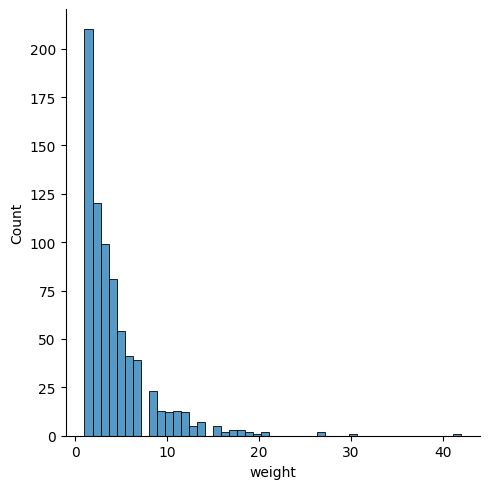

In [162]:
sns.displot(df_edges,x='weight');

<AxesSubplot:xlabel='pre_type', ylabel='weight'>

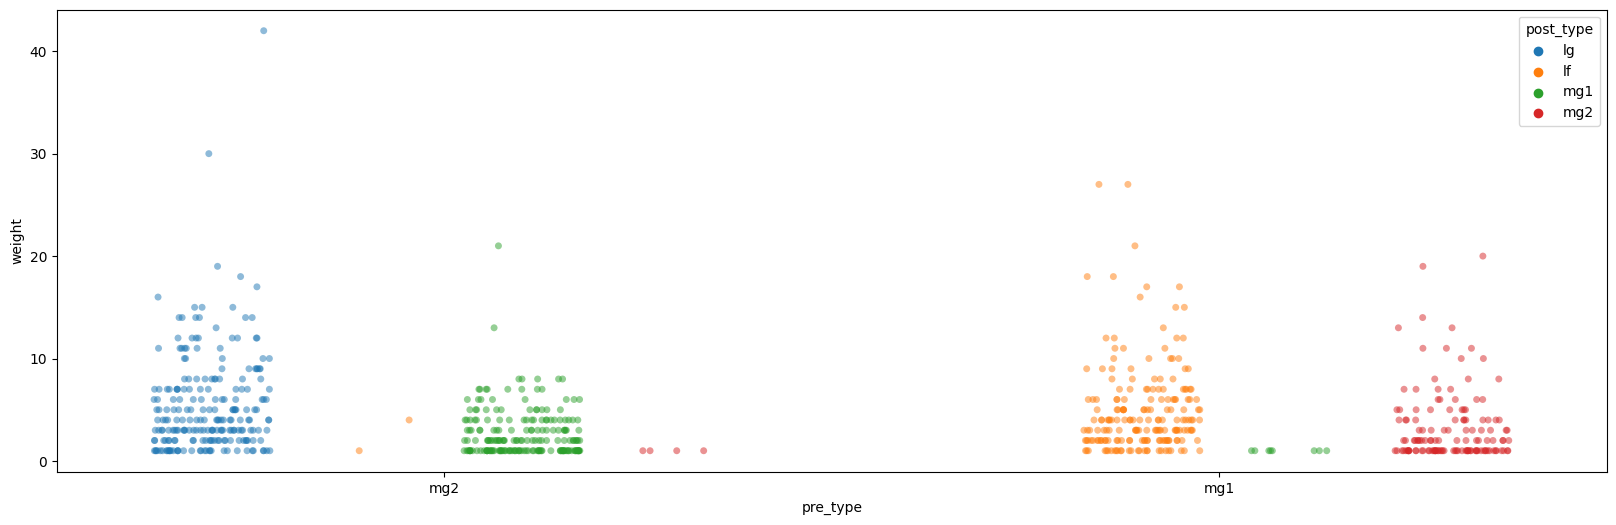

In [163]:
# df_edges['weight'].hist(bins=20)
plt.figure(figsize=(20,6))
sns.stripplot(df_edges,x='pre_type',y='weight',hue='post_type',dodge=True, jitter=0.3,alpha = 0.5)#,split=True)
# sns.displot(df_edges,x='weight',hue='pre_type',multiple='dodge')

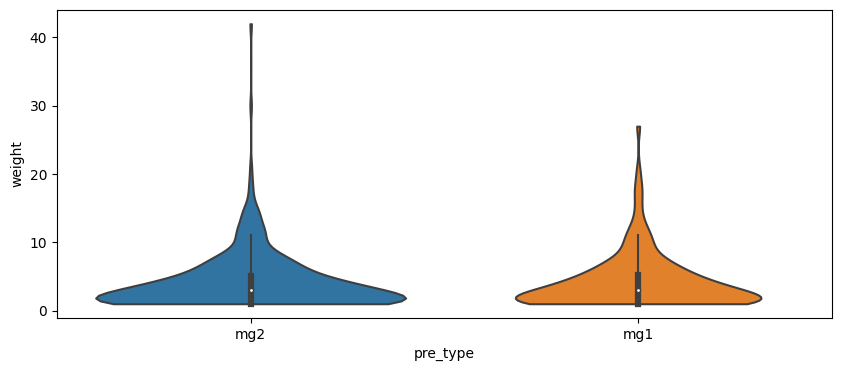

In [164]:
plt.figure(figsize=(10,4))
sns.violinplot(df_edges,x='pre_type',y='weight',scale='count',cut=0);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='pre_type',bw_adjust = 0.5)

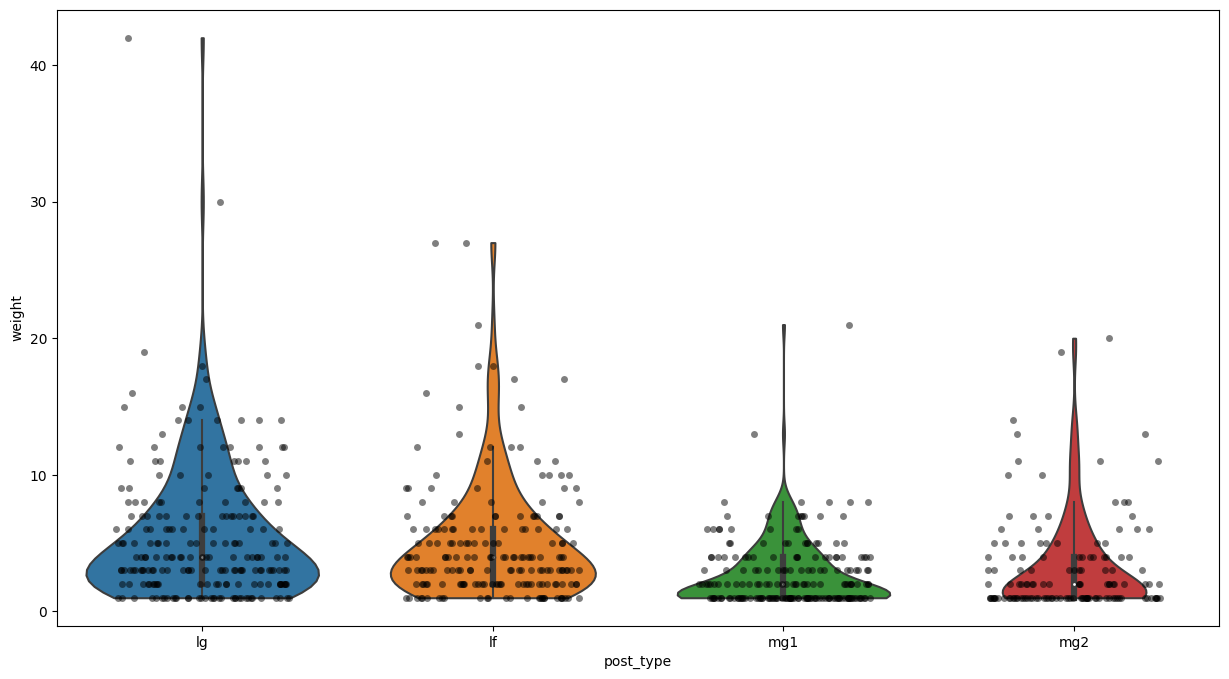

In [165]:
plt.figure(figsize=(15,8))
sns.violinplot(df_edges,x='post_type',y='weight',scale='count',cut=0)
sns.stripplot(df_edges,x='post_type',y='weight',color='black',alpha=0.5,jitter=0.3);
# plt.figure(figsize=(10,4))
# sns.kdeplot(df_edges,x='weight',hue='post_type',bw_adjust = 0.5)

In [166]:
degree_in = ell.degree(mode="in")
degree_out = ell.degree(mode="out")

df_degree = pd.DataFrame({
    'cell_id': [v['name'] for v in ell.vs],
    'converge': degree_in,
    'diverge': degree_out,
    'type': [cell_type[v['name']] for v in ell.vs]
})

with pd.option_context('display.max_rows', 4):
    display(df_degree)

,cell_id,converge,diverge,type
0,119793391,5,0,lg
1,126618353,8,10,mg1
...,...,...,...,...
154,652529320,1,0,lf
155,653504340,2,0,lf


<AxesSubplot:xlabel='type', ylabel='value'>

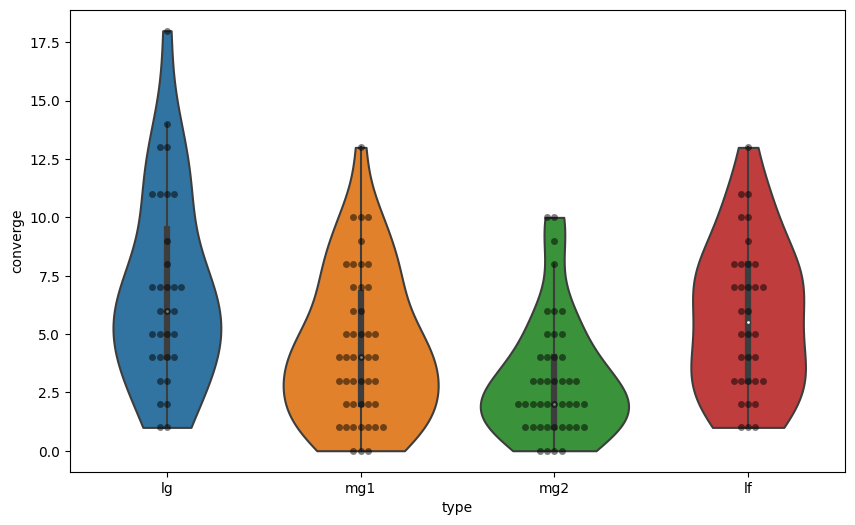

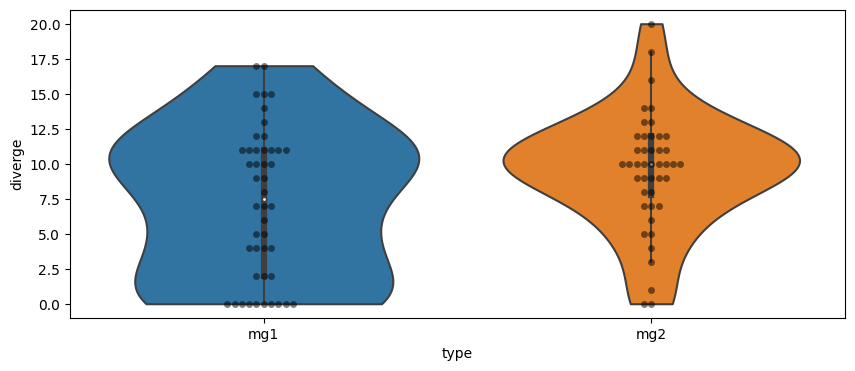

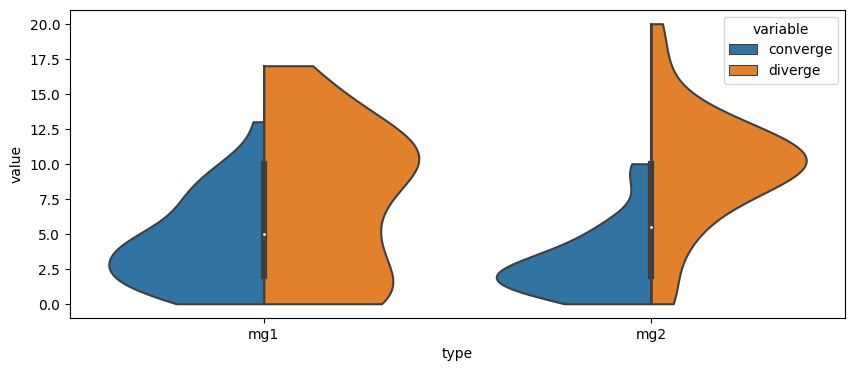

In [167]:
# sns.kdeplot(df_degree,x='converge',hue='type', bw_adjust = 0.75)
plt.figure(figsize=(10,6))
sns.violinplot(df_degree,x='type',y='converge',scale='count',cut=0)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree,x='type',y='converge',color='black',alpha=0.5)#,jitter=0.25)
# sns.stripplot(df_degree,x='type',y='converge',alpha=0.5,jitter=0.25)

plt.figure(figsize=(10,4))
sns.violinplot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],y='diverge',x='type',scale='count',cut=0)
# plt.figure(figsize=(10,4))
sns.swarmplot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='type',y='diverge',color='black',alpha=0.5)



# sns.displot(df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])],x='diverge',hue='type',multiple='dodge')

tmp = df_degree[df_degree['type'].isin(['mg1','mg2','mgx'])].melt(id_vars=['type'], 
            value_vars=['converge', 'diverge'])

plt.figure(figsize=(10,4))
sns.violinplot(tmp,y='value',x='type',hue = 'variable',split=True,scale='count',cut=0)

In [168]:
color_dict = {"mg1": "orange", "lf": "red", "mg2": "purple", "lg": "blue"}

# for cell_type in ell.vs["cell_type"]:

for v in ell.vs:
    try:
        v["color"] = color_dict[v['cell_type']]
    except:
        v["color"] = 'black'
# ell.vs["color"] = [try: color_dict[cell_type] except: 'black' for cell_type in ell.vs["cell_type"]]

In [169]:
color_dict = {"unknown": "brown", "apical dendrite": "red", "basal dendrite": "orange", "axon": "green", "multiple":"gray"}

# for cell_type in ell.vs["cell_type"]:

for e in ell.es:
    try:
        e["color"] = color_dict[e['structure']]
    except:
        e["color"] = 'black'
        # print(e)

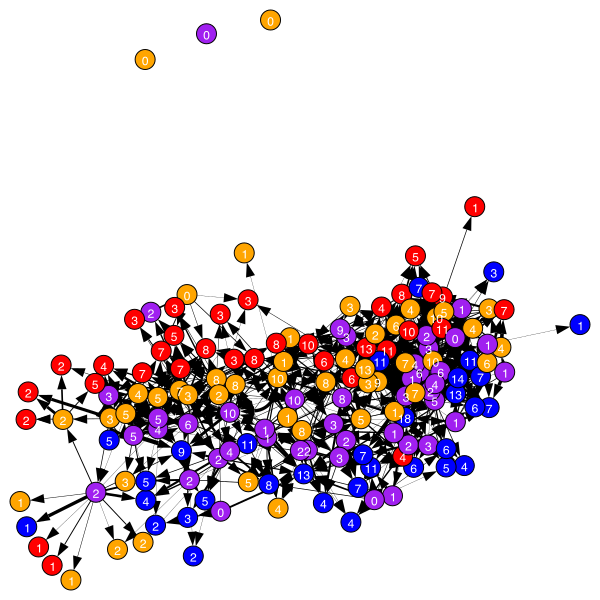

In [172]:
degree_all = ell.degree(mode="in")

# for i,d in enumerate(degree_all):
    # print(ell.vs[i]['cell_type'],d)

# labels = [n['name'] for n in ell.vs]

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all
# visual_style["arrow_size"]=0.1


ig_plot(ell,edge_width = ell.es['weight'],
        vertex_color=ell.vs['color'],
        edge_color = ell.es['color'], 
        **visual_style)#,vertex_label=labels)

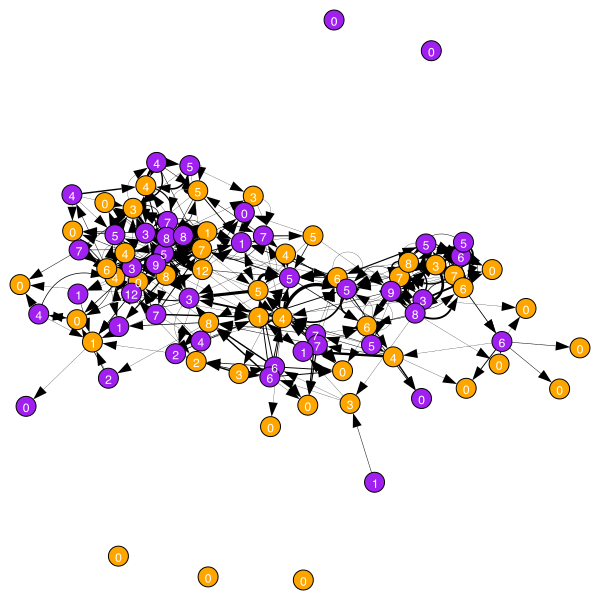

In [176]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if 'mg' in b['cell_type']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'],
        **visual_style)#,vertex_label=labels)

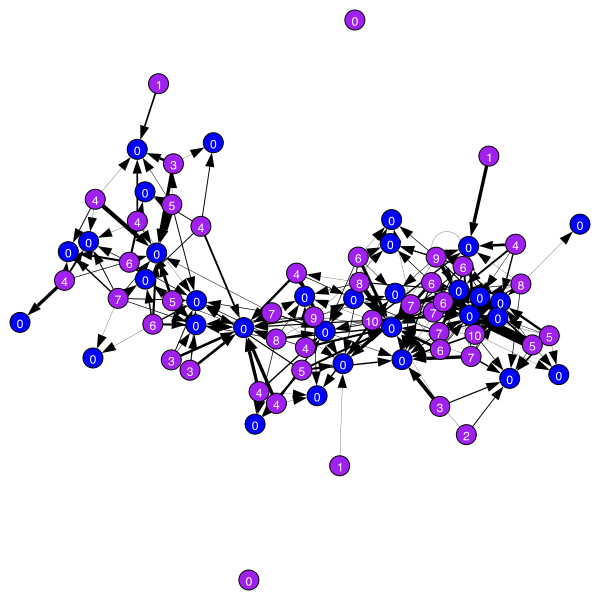

In [177]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

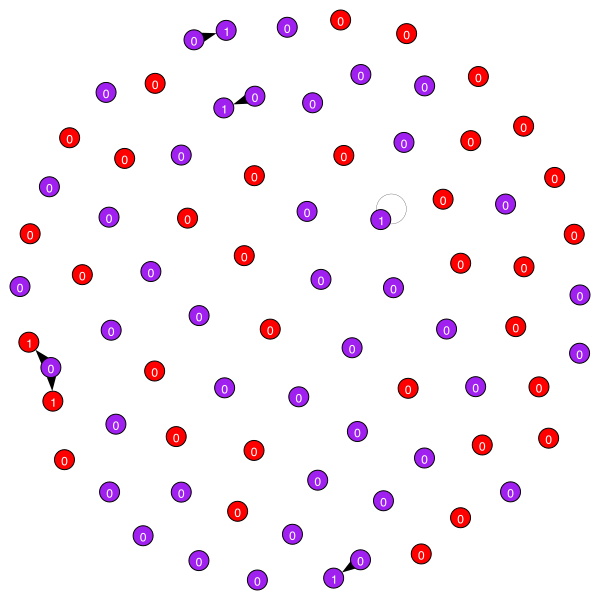

In [178]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg2','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

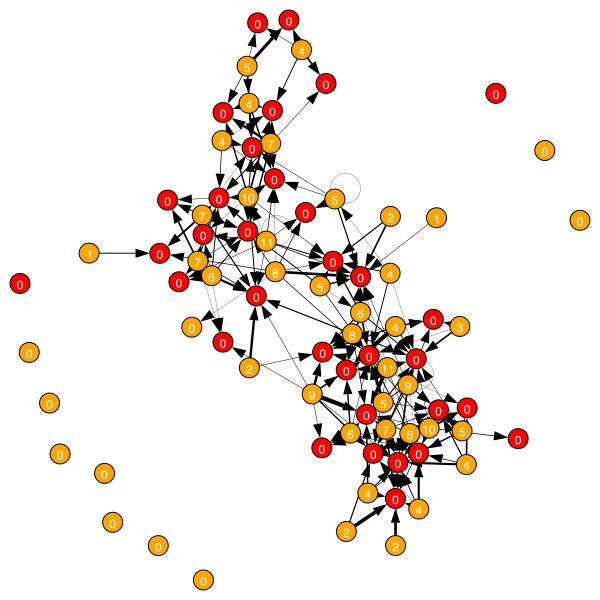

In [187]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lf','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="out")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

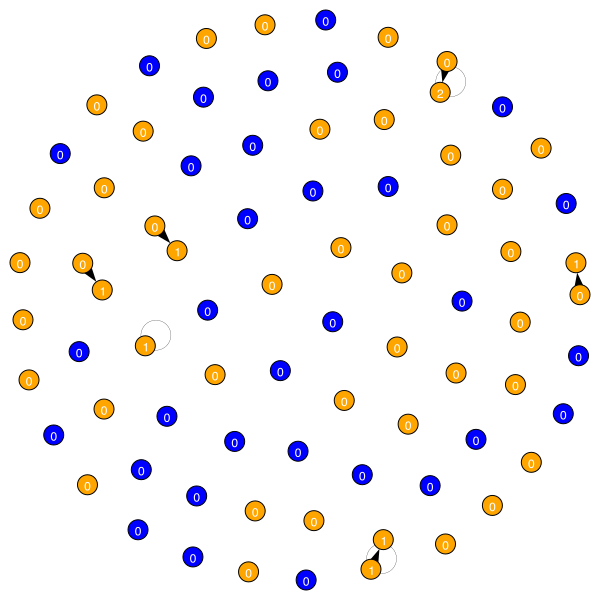

In [188]:
pruned_vs = ell.vs.select([v for v, b in enumerate(ell.vs) if b['cell_type'] in ['mg1','mgx','lg','lx']])

pruned_graph = ell.subgraph(pruned_vs)

degree_all = pruned_graph.degree(mode="in")

visual_style = {}
# visual_style["layout"] = ell.layout("fr")
visual_style["vertex_label_size"] = 12
visual_style["vertex_label_color"] = "white"
visual_style["vertex_label"] = degree_all

ig_plot(pruned_graph,edge_width = pruned_graph.es['weight'],
        vertex_color=pruned_graph.vs['color'],
        edge_color = pruned_graph.es['color'], 
        **visual_style)#,vertex_label=labels)

## Get all pre-synaptic cells to a specific cellID

In [91]:
df_edges[df_edges['post']=='393063300'].groupby('pre').sum(numeric_only=True)

,weight,weight_norm
pre,,
214412684,12,3.0
300210608,2,0.5
387368998,4,1.0
472175645,20,5.0


## Check for duplicates in mg_network

In [19]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [20]:
crest = ecrest(settings_dict,launch_viewer=False)

base_segments = crest.get_base_segments_dict(dirpath)

In [21]:
df_all = pd.DataFrame()
for k,f in nodefiles.items():
    cell = ecrest(settings_dict,filepath = f,launch_viewer=False)
    df = cell.check_duplicates(base_segments)
    if not df.empty:
        df_all = pd.concat([df_all,df]) 
        
display(df_all)

""


# create crest files for post-syn segments not in cells

In [122]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

# Create a base_segments dictionary of all cells

base_segments = {}
for x in nodes:
    cell = ecrest(settings_dict,filepath = nodefiles[x],launch_viewer=False)
    base_segments[cell.cell_data['metadata']['main_seg']['base']] = cell.cell_data['base_segments']

In [125]:
# todo_dict= {}
# post_segs_without_cell = 0
# post_segs_with_cell = 0

all_syn = set()
for x_pre in nodes:
    pre = ecrest(settings_dict,filepath = nodefiles[x_pre],launch_viewer=False)

    # report if the cell is not cell-typed
    if (pre.get_ctype('manual') == []) | (pre.get_ctype('manual') == ''):
        print(f'cell {x_pre} is not cell-typed in json')
    
    # check if the cell is an mg cell and if it has post-synaptic segments labeled
    if ('mg' in pre.get_ctype('manual')) & (pre.cell_data['end_points']['post-synaptic'] != []):

        try:
        # for each synapse
            syn_to_find = set([syn_[3] for syn_ in pre.cell_data['end_points']['post-synaptic']])
            for x_post in nodes:
                post_segs = set([a for b in base_segments[x_post].values() for a in b])    
                syn_to_find = syn_to_find.difference(post_segs)

            all_syn = all_syn.union(syn_to_find)
        
        except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')
        

In [129]:
len(all_syn)

1504

In [ ]:
todo_dict = {}
for post_seg in list(all_syn):
    post = ecrest(settings_dict,segment_id = post_seg,launch_viewer=False)
    todo_dict[post_seg] = set(post.cell_data['base_segments']['unknown'])
    # post_segs_without_cell+=1
    

In [131]:
len(todo_dict)

1504

In [132]:
topop=[]

todo_inds = list(todo_dict.keys())
for k,k_ in itertools.combinations(todo_inds,2):
    if todo_dict[k]&todo_dict[k_]!=set():
        # then they share segments
        topop.append(k_)
topop = np.unique(topop)

In [133]:
len(topop)

208

In [134]:
for segid in topop:
    todo_dict.pop(segid)
    

In [ ]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_post-synaptic')
    



# Find & Delete GLIA "post-synaptic" segments from jsons



In [90]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)

dirpath = Path(settings_dict['save_dir'])
# dirpath = "/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network"

nodes = [child.name.split('_')[2] for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

nodefiles = dict()
for child in sorted(dirpath.iterdir()):
    if (child.name[0]!='.') & (child.is_file()):
        nodefiles[child.name.split('_')[2]] = child
                    

In [91]:
glia_seg = ['479108445']

In [92]:
anno_to_remove = {}

vx_sizes = [16, 16, 30]
# for each node,
for n in nodes:

    # if the node has post-synaptic annotations (the current cell is assumed pre-synaptic)
    pre = ecrest(settings_dict,filepath = nodefiles[n],launch_viewer=False)
    if pre.cell_data['end_points']['post-synaptic'] != []:
        
        for syn_ in pre.cell_data['end_points']['post-synaptic']:
            try: 
                if syn_[3] in glia_seg:
                    anno_to_remove[nodefiles[n]] = syn_


            except IndexError as msg:
                # cellid = x_pre['name']
                print(msg, f'for cell {pre.cell_data["metadata"]["main_seg"]["base"]} -- at least one synapse has no segment id')

In [93]:
anno_to_remove

{PosixPath('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/cell_graph_474357461__2023-05-11 14.05.25.json'): [234128.0,
  308944.0,
  81030.0,
  '479108445']}

In [59]:
f = '/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/todo_post-synaptic/glia/cell_graph_43621743__2023-04-20 08.33.58.json'
pre = ecrest(settings_dict,filepath = f,launch_viewer=True)

updating viewer status message: Current Base Segment Counts: unknown: 1, axon: 0, basal dendrite: 0, apical dendrite: 0, dendrite: 0, multiple: 0


In [94]:
# filepath = json_path / filename
for f,anno in anno_to_remove.items():
    pre = ecrest(settings_dict,filepath = f,launch_viewer=False)
    updated_anno = [i for i in pre.cell_data['end_points']['post-synaptic'] if i[3] not in [anno[3]]]
    pre.cell_data['end_points']['post-synaptic'] = updated_anno
    
    # print(f.name)
    pre.save_cell_graph(directory_path = f.parent, file_name=f.name, save_to_cloud=False); 
    # print(len(pre.cell_data['end_points']['post-synaptic']),len(updated_anno))

Saved cell 474357461 reconstruction locally at 2023-05-12 20.14.53


# GET most recent files (by filename date) in folder

In [155]:
# dirname = 'C:/Users/mpetkova/Dropbox/U19_zebrafish/EMfullres/LateralLineCurlDetector/CREST/right_afferents/'
# # os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'C:/Users/EngertLab/Dropbox/CREST/mariela_fish_credentials.json'

# names = os.listdir(dirname);
# cellid_filename=list();
# for ind in range(len(names)):
#     content = names[ind].split('_')
#     if ('cell' in content):
#         cellid_filename.append(names[ind])
dirpath = Path('/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network')#/todo_pre-synaptic/basal-dendrite')

cellid_filename = [child.name for child in sorted(dirpath.iterdir()) 
         if (child.name[0]!='.') & (child.is_file())] # ignore hidden files]

d={}
for name in cellid_filename:
    ID,content_type,date=name.split('_')[2], name.split('_')[0], name.split('_')[-1]
    date=date[:-5]
    #create entry in dict which holds ID, file type (ex: cell_graph) and file path
    if ID not in d:
        d[ID]=[date, name]
        #if there are multiple files with the same ID, keep the info for the newest one
    else:
        if date>d[ID][0]:
            d[ID][0]=date
            d[ID][1]=name
            print(f'newer file exists for {ID}')
            
# ############################################################################################################################ 
# # Collect all the base segments for each ID
# import json

# base_segs = {}

# for key in d.keys():
#     f = open(dirname+d[key][1])
#     data = json.load(f)
#     base_segs[key]=sum(data['base_segments'].values(),[])
#     f.close()

# ############################################################################################################################ 


# Pre-synaptic reconstruction from synapses

In [80]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


In [84]:
json_path = Path(settings_dict['save_dir']) #/ 'todo_post-synaptic' #/ 'check-duplicates' #'CC unsure'
filename = 'cell_graph_386392158__2023-05-18 11.45.00.json'

crest = ecrest(settings_dict,filepath= json_path / filename, launch_viewer=False)


In [103]:
vx_sizes = [16, 16, 30]

syn_to_find = set([syn_[3] for syn_ in crest.cell_data['end_points']['pre-synaptic'] if int(syn_[1]/vx_sizes[1])>17070])

In [104]:
len(syn_to_find)

55

In [83]:
# [np.asarray(syn_[0:2])/16 for syn_ in crest.cell_data['end_points']['pre-synaptic'] if syn_[3] in ['394395122']]

First, find if any of these post-synaptic segments are already part of reconstructions completed

In [85]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir']))

In [111]:
topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

use reconstruction 299392199
use reconstruction 300472128
use reconstruction 558191083


In [112]:
topop

{'301647214', '393231844', '393249008', '479109096'}

In [113]:
syn_to_find = syn_to_find.difference(topop)

In [114]:
len(syn_to_find)

51

In [115]:
base_segments = crest.get_base_segments_dict(Path(settings_dict['save_dir'])/'todo_pre-synaptic/basal-dendrite')

In [118]:
topop=set()
for k,v in base_segments.items():
    if syn_to_find & v != set():
        # print(f'use reconstruction {k}')
        topop = topop.union(syn_to_find & v)
    

In [119]:
len(topop)

51

In [120]:
syn_to_find = syn_to_find.difference(topop)

In [121]:
len(syn_to_find)

0

create crest files for each of the unidentified post-synaptic partners

In [62]:
path_to_settings_json = '/Users/kperks/Documents/ell-connectome/eCREST-local-files/settings_dict.json'
settings_dict = import_settings(path_to_settings_json)


Save reconstructed_segs as a json to go through manually

In [63]:
for segment_id in sorted(list(todo_dict.keys())):

    cell = ecrest(settings_dict,segment_id = segment_id, launch_viewer=False)
    cell.save_cell_graph(directory_path = Path(settings_dict['save_dir']) / 'todo_pre-synaptic/basal-dendrite')

Creating base segment graph for cell 394395379 Cell Reconstruction
all base locations for 2 obtained from SQL database
graph created among all_base_segs
1 clusters of connected components. Connecting these clusters with nearest base segments.
weak clusters connected
segments without a location connected
1 clusters in graph (note should/would be only 1 if loaded base ID from agglomo fresh)
Created a CREST instance for NEW Reconstruction of 394395379. No file saved yet -- save manually.
Saved cell 394395379 reconstruction locally at 2023-05-18 12.37.49


# Other

## Fix cell_data dictionary keys


In [90]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_305332461__2023-04-01 21.04.03.json"

In [91]:
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [92]:
old_points = cell.cell_data['end_points']
old_points

{'exit volume': [],
 'natural': [],
 'bad alignment': [],
 'uncorrected split': [],
 'artefact': [],
 'natural end': [],
 'uncertain': [],
 'pre-synaptic': [],
 'post-synaptic': []}

In [93]:
end_points = {}
for p in cell.point_types:
    # if p not in cell.cell_data['end_points']:
    end_points[p] = []
        
cell.cell_data['end_points'] = end_points

In [66]:
cell.cell_data['end_points']['natural end'] = old_points['natural']

In [94]:
# cell.cell_data['end_points'].pop('natural')
cell.cell_data['end_points'].keys()

dict_keys(['exit volume', 'natural end', 'uncertain', 'pre-synaptic', 'post-synaptic'])

In [95]:
cell.save_cell_graph(directory_path = filepath.parent, file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp

Saved cell 305332461 reconstruction locally at 2023-04-05 11.20.24


## Figure out what is wrong with a crest file

In [125]:
filepath = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/CREST_reconstructions/mg-network/")
filepath = filepath / "cell_graph_213605530__2023-03-29 22.49.21.json"
cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)

In [127]:
cell.cell_data['end_points']['post-synaptic']

[]

## Fix pre-synaptic to be post-synaptic annotation list in converted crest jsons

In [157]:
json_fix = Path("/Users/kperks/Documents/gdrive/.shortcut-targets-by-id/16q1BuOMfD2ta0Cwq8CjMlRe4rDvbuWC5/ELL_connectome/Complete/synapses/to-crest/conversion_specs_synapse_fix.json")

with open(json_fix,'r') as f:
    cells_to_fix = f.read()
    cells_to_fix = json.loads(cells_to_fix)

In [158]:
cells_to_fix = cells_to_fix['cell_info']

In [163]:
for k,v in cells_to_fix.items():
    try:
        filepath = nodefiles[k]
        cell = ecrest(settings_dict,filepath = filepath,launch_viewer=False)
        cell.cell_data['end_points']['post-synaptic'] = deepcopy(cell.cell_data['end_points']['pre-synaptic'])

        cell.cell_data['end_points']['pre-synaptic'] = []
        # cell.save_cell_graph(directory_path = filepath.parent / 'original', file_name=filepath.name, save_to_cloud=False); #rewrites the original, not with a new time stamp
    except KeyError as msg:
        print(msg)
        continue
        

Saved cell 214412684 reconstruction locally at 2023-04-05 12.11.10
Saved cell 214550811 reconstruction locally at 2023-04-05 12.11.10
Saved cell 215572949 reconstruction locally at 2023-04-05 12.11.10
Saved cell 216129202 reconstruction locally at 2023-04-05 12.11.10
Saved cell 220275752 reconstruction locally at 2023-04-05 12.11.10
Saved cell 297178666 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299497999 reconstruction locally at 2023-04-05 12.11.10
Saved cell 299589324 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300210608 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300316308 reconstruction locally at 2023-04-05 12.11.10
Saved cell 300380579 reconstruction locally at 2023-04-05 12.11.10
"305035439'"
Saved cell 31102601 reconstruction locally at 2023-04-05 12.11.10
Saved cell 387368998 reconstruction locally at 2023-04-05 12.11.10
Saved cell 392213717 reconstruction locally at 2023-04-05 12.11.10
Saved cell 42802314 reconstruction locally at 2023

## Anatomical Clustering